## Part 4 — Occlusion Handling (step-by-step)

מטרה: לייצר **מסכת foreground (היד)** בעזרת שיטות קלאסיות (בלי DL), ואז לבצע קומפוזיט כך שהיד תסתיר את המודל הווירטואלי.

הוידאו אצלך כבר בתיקייה:
- `data/part4_occlusion_hand.mp4`

טווחי זמן לבדיקה (שניות):
- 7.5–8.5
- 17.0–17.9
- 24.5–26.5

המחברת מציגה לכל זמן בדיקה: `frame`, `mask`, `ar`, `composited`.



In [6]:
import os
import cv2
import numpy as np

from config import Part1Config, Part4Config
from tracker import PlanarTracker
from camera import load_calibration_npz
from ar_render import (
    load_mesh_trimesh,
    make_plane_object_points,
    scale_K_to_new_size,
    transform_mesh_to_plane,
    draw_mesh_flat,
    draw_mesh_wireframe,
)
from occlusion import (
    build_occlusion_mask,
    composite_with_occlusion,
    roi_mask_from_points,
)

cfg = Part4Config()
tracker_cfg = Part1Config()  # reusing Part 1 tracking params

print("video:", cfg.video_path)
print("ref:", cfg.reference_path)
print("model:", cfg.model_path)
print("calib:", cfg.calib_output_path)



video: data/part4_occlusion_hand.mp4
ref: data/part4_reference.JPG
model: data/models/86jfmjiufzv2.obj
calib: outputs/camera/calibration.npz


In [7]:
# Optional (only needed for notebook visualization)
try:
    import matplotlib.pyplot as plt
except Exception as e:
    raise RuntimeError(
        "matplotlib is required for visualization in this notebook. "
        "Install it with: pip install matplotlib"
    ) from e


def bgr_to_rgb(img_bgr: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


def show4(a, b, c, d, titles=("frame", "mask", "ar", "composited"), figsize=(14, 8)):
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    imgs = [a, b, c, d]
    for i in range(4):
        r = i // 2
        col = i % 2
        ax[r, col].set_title(titles[i])
        ax[r, col].axis("off")

        im = imgs[i]
        if im.ndim == 2:
            ax[r, col].imshow(im, cmap="gray")
        else:
            ax[r, col].imshow(bgr_to_rgb(im))

    plt.tight_layout()
    plt.show()



In [8]:
# Load reference + tracker
ref = cv2.imread(cfg.reference_path)
if ref is None:
    raise FileNotFoundError(f"Could not read reference: {cfg.reference_path}")

tracker = PlanarTracker(ref, tracker_cfg)

# Load calibration (K, dist)
calib = load_calibration_npz(cfg.calib_output_path)
K_calib = np.asarray(calib.K, dtype=np.float64).reshape(3, 3)
dist = np.asarray(calib.dist, dtype=np.float64).reshape(-1, 1)

# Open video
cap = cv2.VideoCapture(cfg.video_path)
if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video: {cfg.video_path}")

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("fps=", fps, "size=", (W, H))

# Scale K if needed
K = K_calib
if tuple(calib.image_size) != (W, H):
    K = scale_K_to_new_size(K_calib, tuple(calib.image_size), (W, H))
K = np.asarray(K, dtype=np.float64).reshape(3, 3)

# Plane object points (Z=0)
ref_h, ref_w = ref.shape[:2]
ref_aspect = ref_h / float(ref_w)
plane_w = float(cfg.plane_width)
plane_h = float(cfg.plane_width) * ref_aspect
obj_plane = np.ascontiguousarray(make_plane_object_points(plane_w, plane_h), dtype=np.float64).reshape(-1, 3)

# Load + place mesh on plane (same as Part 3)
if cfg.model_path and os.path.exists(cfg.model_path):
    v, f, face_colors = load_mesh_trimesh(cfg.model_path)
else:
    raise FileNotFoundError(f"Model not found: {cfg.model_path}")

if cfg.max_faces and int(cfg.max_faces) > 0 and f.shape[0] > int(cfg.max_faces):
    rng = np.random.default_rng(0)
    idx = rng.choice(f.shape[0], size=int(cfg.max_faces), replace=False)
    f = f[idx]
    if face_colors is not None and face_colors.shape[0] >= idx.max() + 1:
        face_colors = face_colors[idx]

v_plane = transform_mesh_to_plane(
    v,
    plane_w=plane_w,
    plane_h=plane_h,
    scale_frac=cfg.model_scale_frac,
    offset_x_frac=cfg.model_offset_x_frac,
    offset_y_frac=cfg.model_offset_y_frac,
    z_up=True,
    rotate_x_deg=cfg.rotate_x_deg,
    rotate_y_deg=cfg.rotate_y_deg,
    rotate_z_deg=cfg.rotate_z_deg,
)

print("mesh verts:", v_plane.shape[0], "faces:", f.shape[0], "has_face_colors:", face_colors is not None)



fps= 59.973389511032266 size= (1080, 1920)
mesh verts: 169374 faces: 3000 has_face_colors: True


In [9]:
def get_frame_at_time(cap: cv2.VideoCapture, t_s: float) -> np.ndarray:
    cap.set(cv2.CAP_PROP_POS_MSEC, float(t_s) * 1000.0)
    ok, fr = cap.read()
    if not ok or fr is None:
        raise RuntimeError(f"Failed to read frame at t={t_s:.3f}s")
    return fr


def render_mesh_on_frame(frame_bgr: np.ndarray):
    """Returns (ar_frame, verts2d, ok_pose)."""
    Hh, corners, dbg = tracker.track(frame_bgr)
    out = frame_bgr.copy()

    if corners is None:
        return out, None, False

    img_pts = np.asarray(corners, dtype=np.float64).reshape(-1, 2)
    if img_pts.shape != (4, 2) or not np.isfinite(img_pts).all():
        return out, None, False

    try:
        ok_pnp = False
        if hasattr(cv2, "SOLVEPNP_IPPE"):
            try:
                ok_pnp, rvec, tvec = cv2.solvePnP(obj_plane, img_pts, K, dist, flags=int(cv2.SOLVEPNP_IPPE))
            except cv2.error:
                ok_pnp = False
            if not ok_pnp:
                ok_pnp, rvec, tvec = cv2.solvePnP(obj_plane, img_pts, K, dist, flags=int(cv2.SOLVEPNP_ITERATIVE))
        else:
            ok_pnp, rvec, tvec = cv2.solvePnP(obj_plane, img_pts, K, dist, flags=int(cv2.SOLVEPNP_ITERATIVE))
    except cv2.error:
        ok_pnp = False

    if not ok_pnp:
        return out, None, False

    proj, _ = cv2.projectPoints(v_plane, rvec, tvec, K, dist)
    verts2d = proj.reshape(-1, 2)

    # Painter order (far->near) using camera-space Z per face
    R, _ = cv2.Rodrigues(rvec)
    cam = (R @ v_plane.T + tvec).T
    z = cam[:, 2]
    face_depth = z[f].mean(axis=1)
    order = np.argsort(face_depth)[::-1]

    if face_colors is not None:
        out = draw_mesh_flat(out, verts2d, f, face_colors, order=order)
    else:
        out = draw_mesh_wireframe(out, verts2d, f, color=(0, 255, 255), thickness=1)

    return out, verts2d, True


def occlude(frame_bgr: np.ndarray, ar_bgr: np.ndarray, verts2d: np.ndarray | None, prev_bgr: np.ndarray | None):
    roi = None
    if verts2d is not None and int(cfg.roi_expand_px) > 0:
        roi = roi_mask_from_points((frame_bgr.shape[0], frame_bgr.shape[1]), verts2d, expand_px=int(cfg.roi_expand_px))

    mask = build_occlusion_mask(
        frame_bgr,
        prev_bgr,
        cr_min=int(cfg.ycrcb_cr_min),
        cr_max=int(cfg.ycrcb_cr_max),
        cb_min=int(cfg.ycrcb_cb_min),
        cb_max=int(cfg.ycrcb_cb_max),
        motion_diff_thresh=int(cfg.motion_diff_thresh),
        open_ksize=int(cfg.morph_open_ksize),
        close_ksize=int(cfg.morph_close_ksize),
        morph_iters=int(cfg.morph_iters),
        roi_mask=roi,
    )

    comp = composite_with_occlusion(frame_bgr, ar_bgr, mask)
    return mask, comp



probe_times: [7.5, 8.0, 8.5, 17.0, 17.45, 17.9, 24.5, 25.5, 26.5]


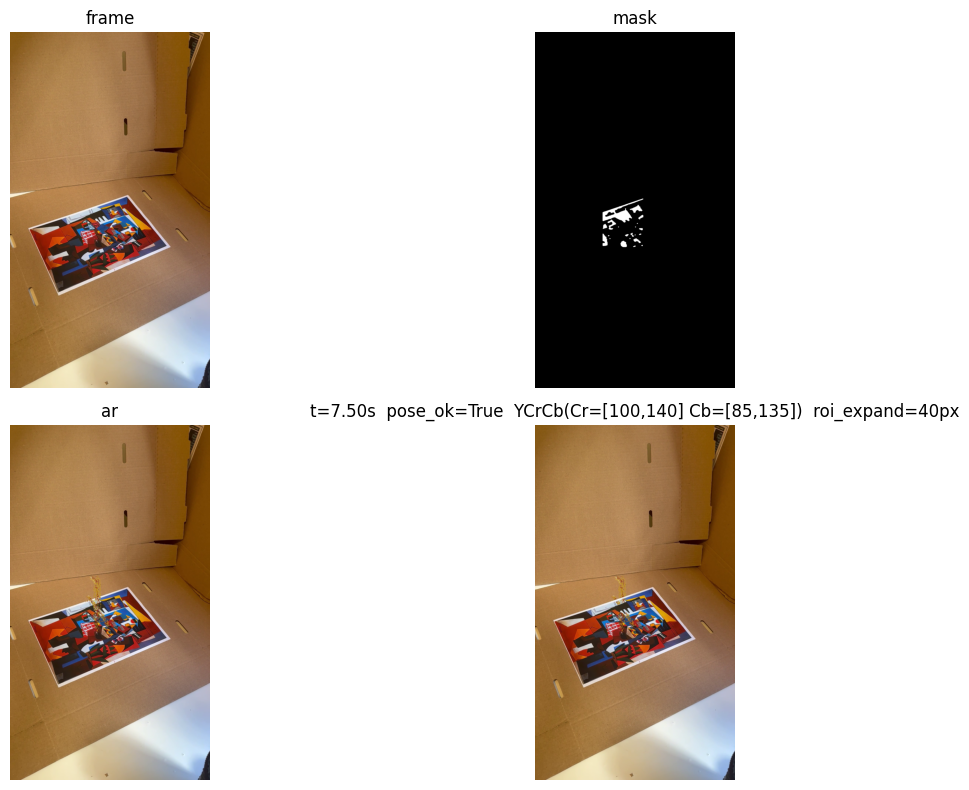

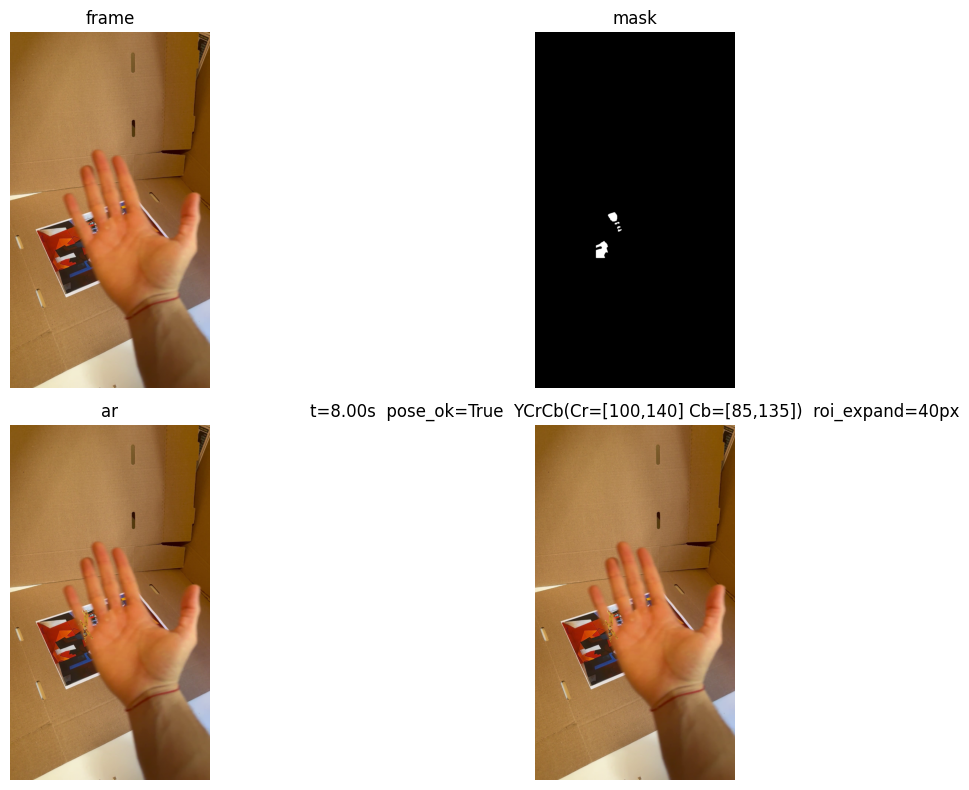

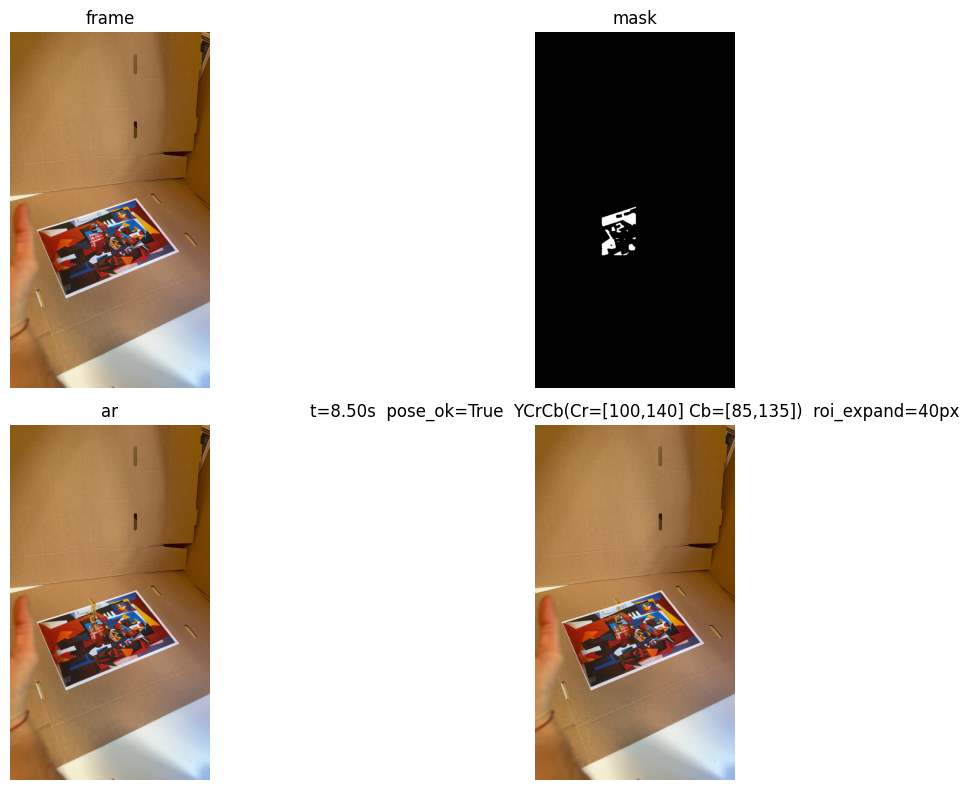

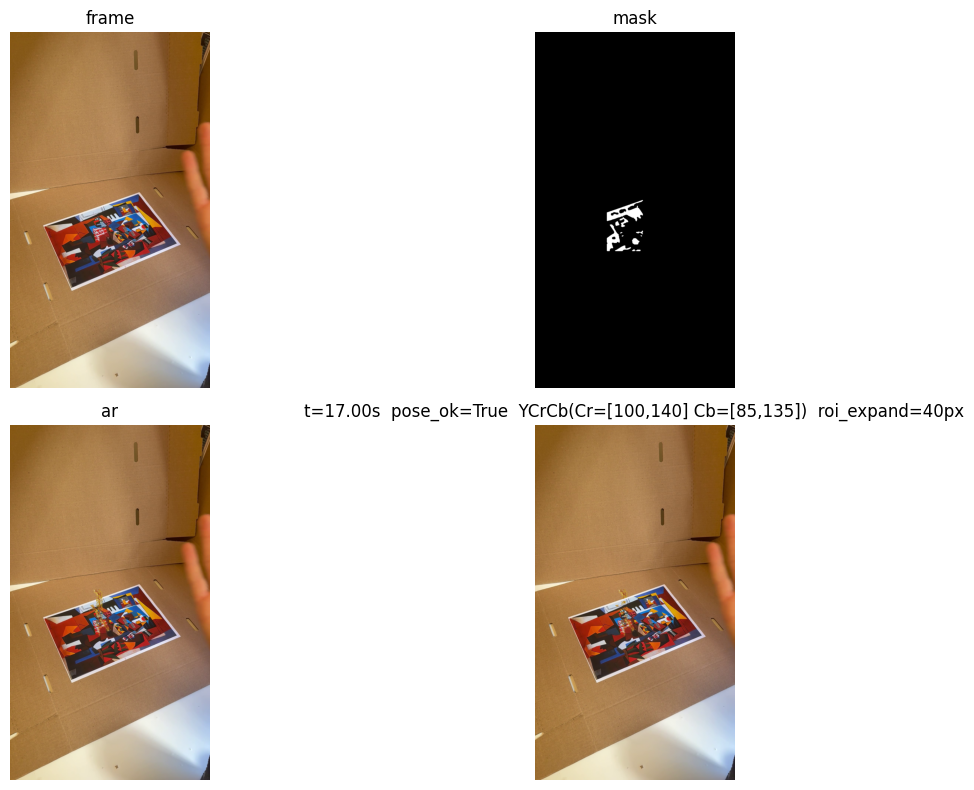

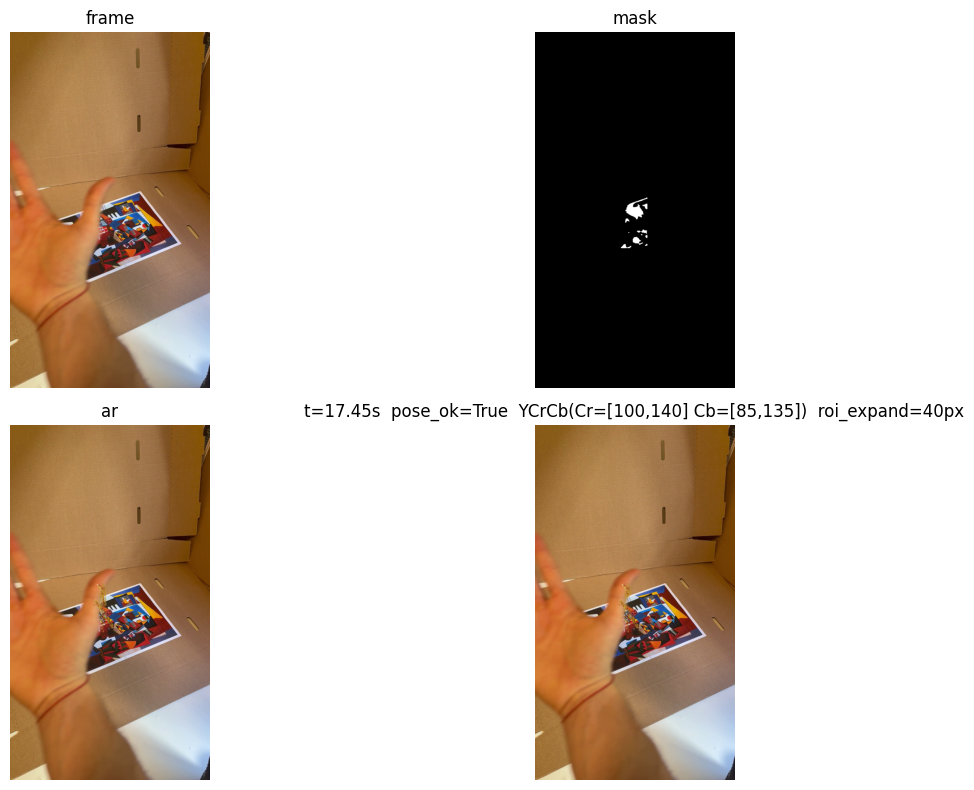

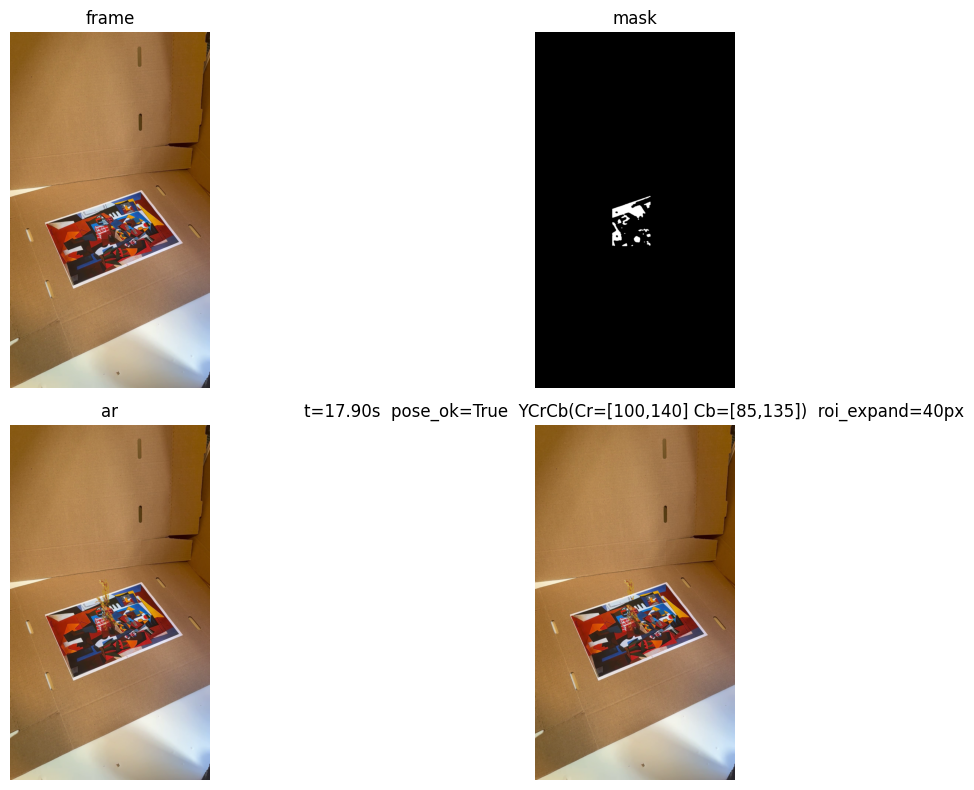

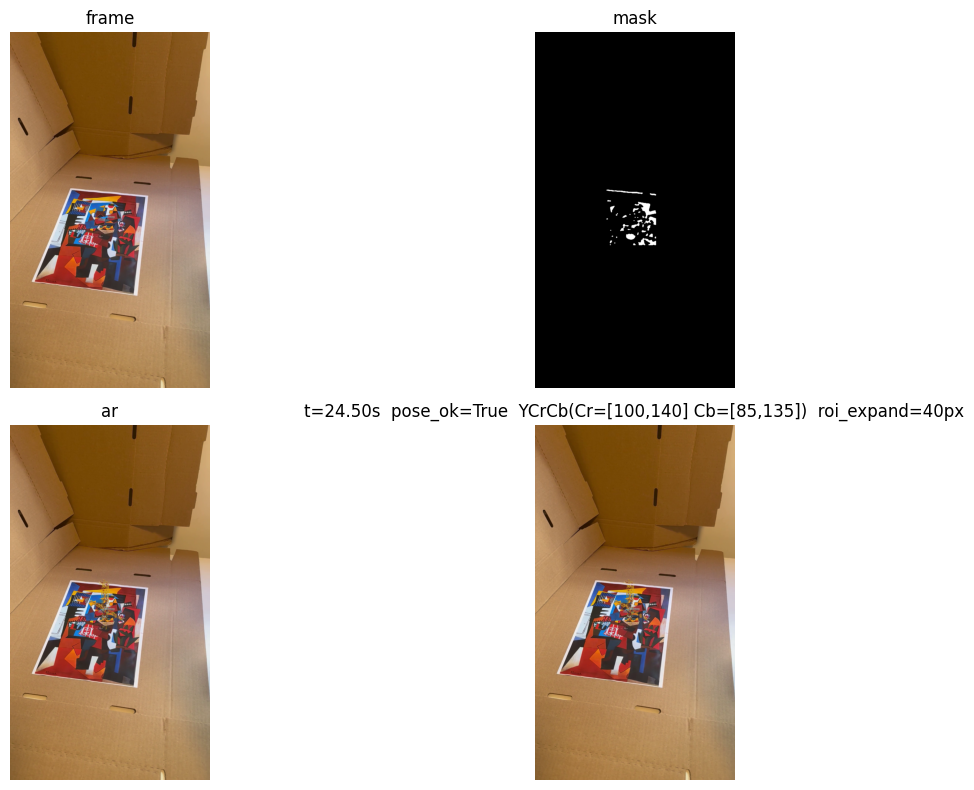

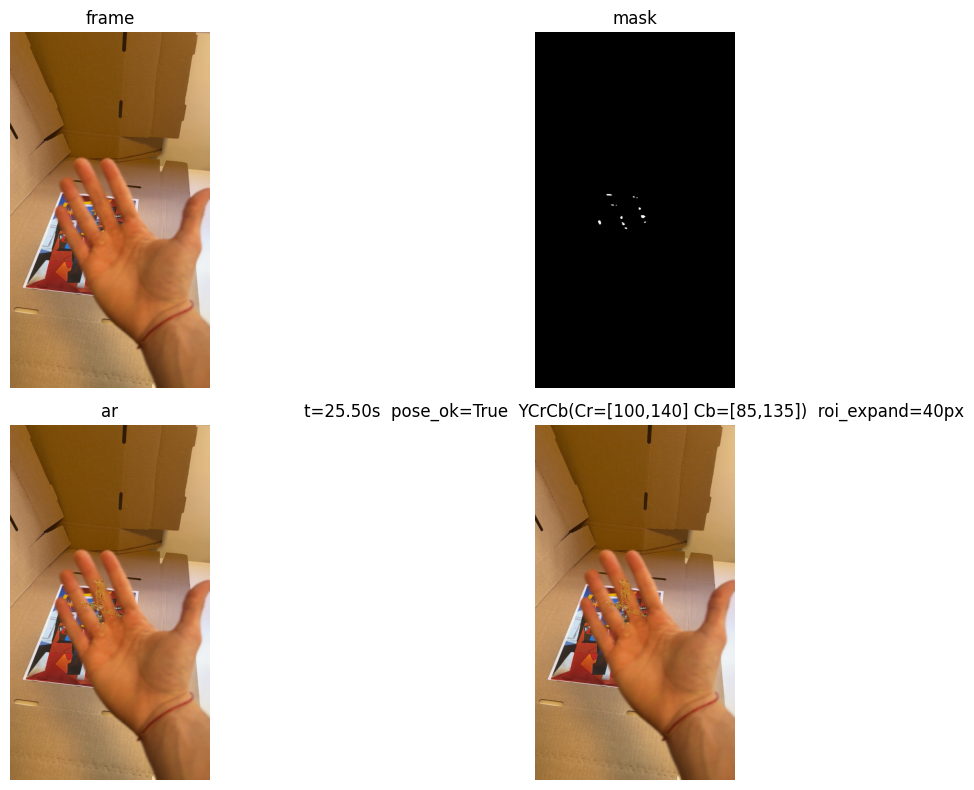

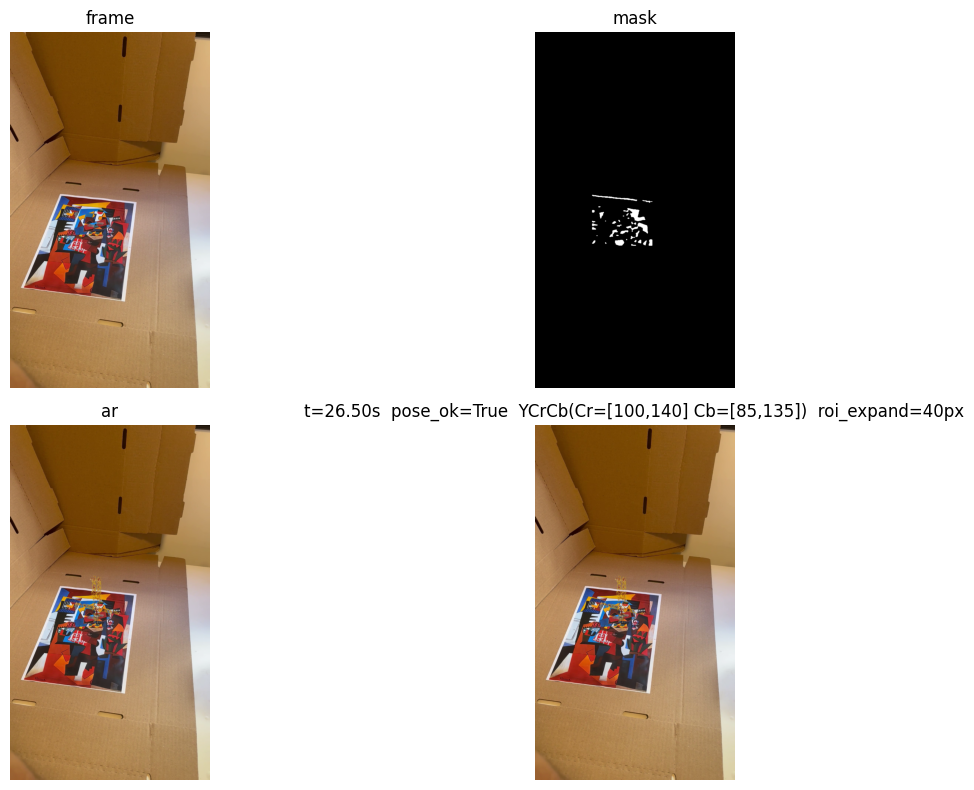

In [10]:
# Probe a few frames inside each window
# Tip: if the mask is too big/small, tune Part4Config thresholds in config.py.

probe_times = []
for (t0, t1) in cfg.probe_windows_s:
    probe_times.extend([t0, (t0 + t1) * 0.5, t1])

probe_times = [float(t) for t in probe_times]
print("probe_times:", probe_times)

prev = None
for t in probe_times:
    frame = get_frame_at_time(cap, t)
    ar, verts2d, ok_pose = render_mesh_on_frame(frame)

    mask, comp = occlude(frame, ar, verts2d, prev)

    title = (
        f"t={t:.2f}s  pose_ok={ok_pose}  "
        f"YCrCb(Cr=[{cfg.ycrcb_cr_min},{cfg.ycrcb_cr_max}] Cb=[{cfg.ycrcb_cb_min},{cfg.ycrcb_cb_max}])  "
        f"roi_expand={cfg.roi_expand_px}px"
    )

    show4(frame, mask, ar, comp, titles=("frame", "mask", "ar", title))
    prev = frame

